# An implementation of the Ant miner paper for Emotion Recognition

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [3]:
df = pd.read_csv("Resources/Ravdess Dataset.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,-675.852,-820.630,-372.474,156.448,0.455,-1.471,68.959,-15.910,217.757,72.966,...,15.036,-3.957,32.880,0.023,-110.137,112.829,20.504,-0.442,17.036,neutral
1,-640.294,-783.178,-358.277,154.661,0.411,-1.555,64.627,-47.438,218.073,76.974,...,12.265,-4.655,30.513,-0.725,-82.309,67.398,13.982,-1.941,19.824,neutral
2,-677.497,-825.274,-375.799,157.171,0.415,-1.537,66.738,-79.028,208.915,73.381,...,22.398,-2.424,37.887,-0.037,-169.023,170.742,30.984,0.124,18.527,neutral
3,-659.499,-809.578,-356.445,164.199,0.455,-1.502,61.317,-70.403,214.674,75.767,...,10.528,1.095,18.721,-0.004,-59.714,50.999,13.634,-0.887,10.296,neutral
4,-698.072,-857.808,-409.923,156.816,0.281,-1.594,70.695,-55.799,221.357,70.646,...,24.944,-2.291,42.875,0.022,-253.151,210.330,35.594,-0.635,28.814,calm


In [172]:
#Level of discretization of the continuous data
bins = 3

(array([364., 845., 231.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

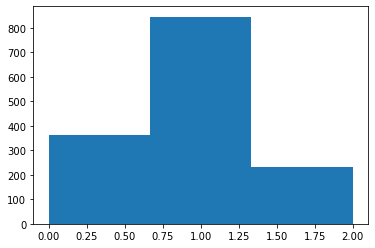

In [174]:
plt.hist(pd.cut(df['f0'], bins=bins, labels=range(bins)), bins = bins)

In [175]:
discreet = pd.DataFrame()

In [176]:
for column in df.drop('class', axis=1).columns:
    discreet[column] = pd.cut(df[column], bins=bins, labels=range(bins))
    #discreet[column] = pd.qcut(df[column], q=bins, labels=range(bins))

In [177]:
discreet['class'] = df['class']
discreet.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,1,1,1,1,2,0,1,2,1,2,...,0,0,0,0,2,0,0,0,0,neutral
1,1,1,1,1,2,0,1,1,1,2,...,0,0,0,0,2,0,0,0,0,neutral
2,1,1,1,1,2,0,1,1,1,2,...,0,1,0,0,2,0,0,0,0,neutral
3,1,1,1,1,2,0,1,1,1,2,...,0,1,0,0,2,0,0,0,0,neutral
4,0,1,1,1,1,0,1,1,1,1,...,0,1,0,0,1,1,0,0,0,calm


In [178]:
emotions = discreet['class'].unique()
emotions

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust',
       'surprised'], dtype=object)

In [179]:
train, test = np.split(discreet.sample(frac=1), [int(0.75*len(discreet))])
train_len = len(train)
test_len = len(test)
total_len = train_len + test_len
test_len, train_len, total_len

(360, 1080, 1440)

# Entropy values
H will be a matrix of size (bins x features). Computed in a vectorized way to save time (This would take like 10 mins if it was in a for loop, now it takes 10s). <br>
Ok fine I'm looping through the 6 emotions so techhhhnically it's not fully vectorized. Anyway we're computing H only once so I took lite

In [180]:
H = np.zeros((bins, len(train.columns)-1, len(emotions)))

In [181]:
train.loc[train['class']==emotion].drop('class', axis=1).apply(pd.Series.value_counts)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f642,f643,f644,f645,f646,f647,f648,f649,f650,f651
0,23,8,15,2,0,140,27,12,7,3,...,120,121,44,140,152,8,101,125,132,145
1,121,134,127,83,52,11,115,91,124,86,...,28,30,101,12,0,43,44,26,20,7
2,8,10,10,67,100,1,10,49,21,63,...,4,1,7,0,0,101,7,1,0,0


In [182]:
# The most compute intensive step
for e, emotion in enumerate(emotions):
            H[:, :, e] = train.loc[train['class']==emotion].drop('class', axis=1).apply(pd.Series.value_counts).to_numpy()
#H

In [183]:
sums = np.sum(H, axis=2)
#sums

In [184]:
repeated_sums = np.repeat(sums[:, :, np.newaxis], H.shape[2], axis=2)
#repeated_sums[:, :, 1]

In [185]:
P = np.divide(H, repeated_sums, out=np.zeros_like(H), where=repeated_sums!=0)

In [186]:
logP = np.log2(P, out=np.zeros_like(P), where=P>0)
#logP

In [187]:
H = -np.sum(np.multiply(P, logP), axis=2)
#H

In [188]:
features = discreet.drop('class', axis=1).columns
logK = np.log2(len(emotions))

In [478]:
#Hyperparameters
min_coverage = 10
max_uncovered = 10
n_ants = 10
max_dups = 2

In [479]:
class Rule:
    def __init__(self):
        self.terms = {}
        self.emotion = None
        self.numerosity = 0
        self.coverage = len(train_set)
    
    def match(self, instance):
        for key, value in instance.items():
            if key in self.terms and self.terms[key] != value:
                return False
        return True
    
    def match_set(self):
        dic = {'f' + str(key): val for key, val in self.terms.items()}
        return train_set.loc[np.all(train_set[list(dic)]== pd.Series(dic), axis=1)]
    
    def unmatch_set(self):
        dic = {'f' + str(key): val for key, val in self.terms.items()}
        return train_set.loc[~np.all(train_set[list(dic)]== pd.Series(dic), axis=1)]
    
    def correct_set(self):
        matches = self.match_set()
        return matches.loc[matches['class'] == self.emotion]
    
    def exists(self, feature):
        return feature in self.terms
        
    def coverage_with_new_term(self, term):
        dupTerms = copy.deepcopy(self.terms)
        dupTerms[term['feature']] = term['class']
        dic = {'f' + str(key): val for key, val in dupTerms.items()}
        return len(train_set.loc[np.all(train_set[list(dic)]== pd.Series(dic), axis=1)])
            
    def addTerm(self, term, coverage):
        self.terms[term['feature']] = term['class']
        self.numerosity += 1
        self.coverage = coverage
        
    def quality(self):
        matches = self.match_set()
        unmatches = self.unmatch_set()
        TP = len(matches.loc[matches['class'] == self.emotion])
        FP = len(matches.loc[matches['class'] != self.emotion])
        FN = len(unmatches.loc[unmatches['class'] == self.emotion])
        TN = len(unmatches.loc[unmatches['class'] != self.emotion])
        
        sens = TP / (TP + FN)
        spec = TN / (FP + TN)
        
        return sens * spec
        
    def prune(self):
        pass
        

In [480]:
def normalize_probs(probs):
    return probs / np.sum(probs)

In [481]:
class Ant:
    def __init__(self, index):
        self.index = index
        self.rule = Rule()  
    
    def traverse(self, T):
        x = len(features) - self.rule.numerosity
        Eta = logK - H
        denom = x * np.sum(Eta, axis=0)
        Eta = np.divide(Eta, denom)
        
        Probs = np.multiply(Eta, T)
        denom = x * np.sum(Probs, axis=0)
        Probs = np.divide(Probs, denom)
        
        should_continue = True
        while(should_continue):
            tries = 100
            flattened = Probs.flatten()
            while(tries):
                chosen = int(np.random.choice(len(flattened), 1, p=flattened))
                term = {'feature': chosen % len(features), 'class': chosen // len(features)}
                new_cov = self.rule.coverage_with_new_term(term)
                if new_cov >= min_coverage:
                    self.rule.addTerm(term, new_cov)
                    print("Added " + str(term))
                    
                    Probs[:, term['feature']] = 0
                    Probs = normalize_probs(Probs)
                    
                    should_continue = True
                    break
                tries -= 1
                should_continue = False
                
    def set_emotion(self):
        matches = self.rule.match_set()
        self.rule.emotion = matches['class'].mode()[0]
        

In [482]:
train_set = train

In [483]:
DiscoveredRuleList = []

In [ ]:
while len(train_set) > max_uncovered:
    T = np.ones_like(H) * (1 / np.sum(bins * len(features)))
    prev_rules = []
    prev_qualities = []
    dups = 0
    for a in range(n_ants):
        ant = Ant(a)
        print("initialized ant " + str(a))
        ant.traverse(T)
        for prev_rule in prev_rules:
            if ant.rule == prev_rule:
                dups += 1
        else:
            ant.set_emotion()
            Q = ant.rule.quality()
            
            mask = np.zeros_like(H)
            mask[list(ant.rule.terms.values()), list(ant.rule.terms)] = 1
            T = T + np.multiply(T, mask) * Q
            
            prev_rules.append(ant.rule)
            prev_qualities.append(Q)
        if dups > max_dups:
            break
            
    imax = np.argmax(prev_qualities)
    DiscoveredRuleList.append(prev_rules[imax])
    corrects = ant.rule.correct_set()
    train_set = pd.concat([train_set, corrects, corrects]).drop_duplicates(keep=False)
        

initialized ant 0
Added {'feature': 216, 'class': 0}
Added {'feature': 296, 'class': 0}
Added {'feature': 102, 'class': 1}
Added {'feature': 351, 'class': 1}
Added {'feature': 156, 'class': 0}
Added {'feature': 376, 'class': 1}
Added {'feature': 70, 'class': 1}
Added {'feature': 627, 'class': 0}
initialized ant 1
Added {'feature': 204, 'class': 1}
Added {'feature': 452, 'class': 2}
Added {'feature': 206, 'class': 1}
Added {'feature': 648, 'class': 0}
Added {'feature': 536, 'class': 1}
Added {'feature': 97, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 281, 'class': 0}
Added {'feature': 250, 'class': 1}
Added {'feature': 512, 'class': 1}
Added {'feature': 90, 'class': 0}
Added {'feature': 312, 'class': 1}
Added {'feature': 561, 'class': 0}
Added {'feature': 40, 'class': 1}
Added {'feature': 508, 'class': 1}
initialized ant 2
Added {'feature': 444, 'class': 2}
Added {'feature': 363, 'class': 2}
Added {'feature': 587, 'class': 1}
Added {'feature': 352, 'class': 1}
Added

Added {'feature': 36, 'class': 0}
Added {'feature': 254, 'class': 0}
Added {'feature': 199, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 144, 'class': 1}
initialized ant 9
Added {'feature': 201, 'class': 2}
Added {'feature': 382, 'class': 2}
Added {'feature': 163, 'class': 2}
Added {'feature': 14, 'class': 0}
Added {'feature': 579, 'class': 0}
Added {'feature': 511, 'class': 1}
initialized ant 0
Added {'feature': 14, 'class': 0}
Added {'feature': 61, 'class': 2}
initialized ant 1
Added {'feature': 612, 'class': 2}
Added {'feature': 162, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 28, 'class': 1}
Added {'feature': 135, 'class': 1}
initialized ant 2
Added {'feature': 116, 'class': 2}
Added {'feature': 356, 'class': 1}
Added {'feature': 630, 'class': 1}
Added {'feature': 33, 'class': 1}
Added {'feature': 374, 'class': 1}
initialized ant 3
Added {'feature': 402, 'class': 2}
Added {'feature': 605, 'class': 1}
initialized ant 4
Added {'feature': 108, 

# Just testing

In [397]:
np.unique(np.random.choice(4, 1000, p=[0, 0.33, 0.33, 0.34]), return_counts=True)

(array([1, 2, 3]), array([335, 323, 342], dtype=int64))

In [378]:
x = len(features) - 0
Eta = logK - H
denom = x * np.sum(Eta, axis=0)
Eta = np.divide(Eta, denom)

T = np.random.rand(H.shape[0], H.shape[1])
Probs = np.multiply(Eta, T)
denom = x * np.sum(Probs, axis=0)
Probs = np.divide(Probs, denom)
np.sum(Probs)

1.0

In [116]:
flattened = Probs.flatten()
num = np.random.choice(len(flattened), 1, p=flattened)
col = num % 652
row = num // 652
int(col), int(row)

(468, 4)